# SSL and CNN for Multilabel Classification

In [17]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
# Load CSV file
file_path = r"MATWI\labels.csv"
df = pd.read_csv(file_path)
# Drop rows where 'type' is NaN or empty
df = df.dropna(subset=['type', 'wear', 'ImageFile'])  # Remove rows where 'type' is NaN
df = df[df['type'].str.strip() != '']  # Remove rows where 'type' is an empty string or whitespace

print(df['type'].value_counts())
df['flank_wear'] = df['type'].apply(lambda x: 1 if x == 'flank_wear' else (1 if x == "flank_wear+adhesion" else 0))
df["adhesion"] = df["type"].apply(lambda x: 1 if x == "adhesion" else (1 if x == "flank_wear+adhesion" else 0))

df["Images"] = df["ImageFile"].apply(lambda x: cv2.resize(cv2.imread(x), (224, 224)))  # Load and resize images

train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['type'])
#train_df = df[df['Set'].isin([1, 2, 3, 5, 6, 7, 8, 10, 11, 12])]
#test_df = df[df['Set'].isin([4, 9, 13])]
# Count occurrences of each type in the training dataset

flank_wear_count = train_df['flank_wear'].sum()
adhesion_count = train_df['adhesion'].sum()

# Print label counts in the training set
print("Counts of 'flank_wear' and 'adhesion' labels in the training set:")
print(f"Train Flank Wear count: {flank_wear_count}")
print(f"Train Adhesion count: {adhesion_count}")
train_df , val_df = train_test_split(train_df, test_size = 0.2, random_state = 42, stratify = train_df['type'])
val_df, tst_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['type'])
print("Counts of 'flank_wear' and 'adhesion' labels in the test set:")
print("Test Flank Wear count: " ,tst_df['flank_wear'].sum())
print("Test Adhesion count: " ,tst_df['adhesion'].sum())
# Prepare images and labels from the DataFrame
X_train = np.array(train_df['Images'].tolist()) / 255.0  # Normalize training images
y_train = np.array(train_df[["flank_wear", "adhesion"]])


# For validation data
X_val = np.array(val_df['Images'].tolist()) / 255.0  # Normalize validation images
y_val = np.array(val_df[["flank_wear", "adhesion"]])

X_test = np.array(tst_df['Images'].tolist()) / 255.0  # Normalize test images
y_test = np.array(tst_df[["flank_wear", "adhesion"]])


type
flank_wear             1149
flank_wear+adhesion     335
adhesion                179
Name: count, dtype: int64
Counts of 'flank_wear' and 'adhesion' labels in the training set:
Train Flank Wear count: 1187
Train Adhesion count: 411
Counts of 'flank_wear' and 'adhesion' labels in the test set:
Test Flank Wear count:  149
Test Adhesion count:  52


In [21]:
def create_rotation_dataset(images, max_samples=None):
    if max_samples:
        images = images[:max_samples // 4]  # Only take enough images to match max_samples with 4 rotations each

    augmented_images = []
    labels = []

    rotations = [0, 1, 2, 3]  # Corresponds to 0°, 90°, 180°, 270°
    for angle, label in zip(rotations, range(len(rotations))):
        rotated_set = np.array([np.rot90(img, k=angle) for img in images])  # Rotate all images at once
        augmented_images.append(rotated_set)
        labels.extend([label] * len(images))  # Extend labels with the same rotation label

    # Combine all rotated images and labels
    rotated_images = np.concatenate(augmented_images, axis=0)
    rotation_labels = np.array(labels)

    return rotated_images, rotation_labels

# Example Usage
rotated_images_train, rotation_labels_train = create_rotation_dataset(X_train, max_samples=5000)  # Use max 5000 samples
rotated_images_val, rotation_labels_val = create_rotation_dataset(X_val, max_samples=1000)  # Use max 1000 samples

print(f"Rotated Training Data: {rotated_images_train.shape}, Labels: {rotation_labels_train.shape}")
print(f"Rotated Validation Data: {rotated_images_val.shape}, Labels: {rotation_labels_val.shape}")


Rotated Training Data: (4256, 224, 224, 3), Labels: (4256,)
Rotated Validation Data: (664, 224, 224, 3), Labels: (664,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
# Step 2: Define the Pretext Task Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze ResNet50 layers for pretext training

# Add rotation prediction layers
ssl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 classes for rotation prediction
])

ssl_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Step 3: Train on Pretext Task
print("Pretraining on pretext task (rotation prediction)...")
ssl_model.fit(rotated_images_train, rotation_labels_train,
              validation_data=(rotated_images_val, rotation_labels_val),
              epochs=2, batch_size=32)


Pretraining on pretext task (rotation prediction)...
Epoch 1/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.2616 - loss: 1.4829 - val_accuracy: 0.2636 - val_loss: 1.3542
Epoch 2/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.3883 - loss: 1.2935 - val_accuracy: 0.6220 - val_loss: 1.0549


In [44]:
# Extract features from the ResNet50 model (base_model)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the layers of ResNet50

# Extract features from the training and validation sets using the base_model
train_features = base_model.predict(X_train)
val_features = base_model.predict(X_val)

print(f"Train Features Shape: {train_features.shape}")
print(f"Validation Features Shape: {val_features.shape}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 941ms/step
Train Features Shape: (1064, 7, 7, 2048)
Validation Features Shape: (166, 7, 7, 2048)


In [46]:
# Step 6: Define CNN Model for Downstream Task (Multi-Label Classification)
cnn_model = models.Sequential([
    layers.InputLayer(input_shape=train_features.shape[1:]),  # Match feature shape from base_model
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid')  # Output for multi-label classification (flank_wear, adhesion)
])

# Step 7: Compile CNN Model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',  # Multi-label classification loss
                  metrics=['accuracy'])

# Step 8: Fine-Tune the CNN Model on the Downstream Task
cnn_model.fit(train_features, y_train, validation_data=(val_features, y_val),
              epochs=2, batch_size=32)


Epoch 1/2


C:\Users\beyza\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8617 - loss: 0.5575 - val_accuracy: 0.8916 - val_loss: 0.4863
Epoch 2/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8788 - loss: 0.5545 - val_accuracy: 0.8916 - val_loss: 0.4830


In [48]:
# Step 1: Generate predictions for the test set
test_features = base_model.predict(X_test)  # Use base_model to extract features for the test set
y_pred = cnn_model.predict(test_features)

# Since we are doing multi-label classification, we'll threshold predictions at 0.5 for each class
y_pred = (y_pred > 0.5).astype(int)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


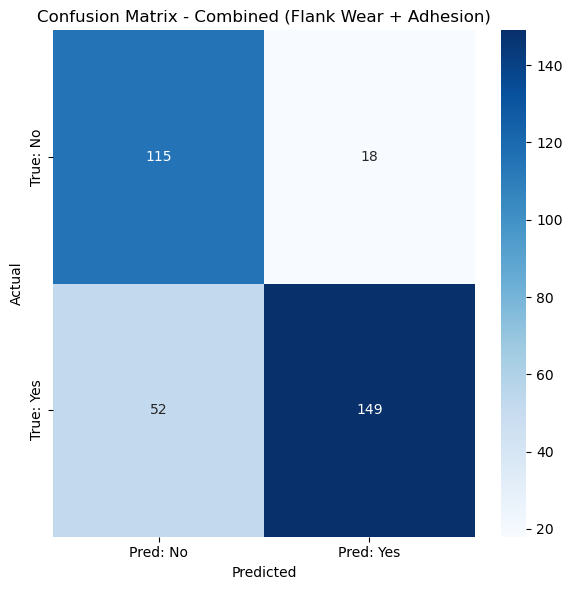

In [66]:
# Flatten the true and predicted labels
y_test_flat = y_test.reshape(-1)  # Flatten the true labels (flank_wear and adhesion)
y_pred_flat = y_pred.reshape(-1)  # Flatten the predicted labels (flank_wear and adhesion)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: No', 'Pred: Yes'], yticklabels=['True: No', 'True: Yes'])
plt.title('Confusion Matrix - Combined (Flank Wear + Adhesion)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



In [56]:
import pandas as pd

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Flank Wear': [precision[0], recall[0], f1[0]],
    'Adhesion': [precision[1], recall[1], f1[1]],
    'Micro Average': [precision_micro, recall_micro, f1_micro],
    'Macro Average': [precision_macro, recall_macro, f1_macro]
})

# Print the metrics table
print(metrics_df)


      Metric  Flank Wear  Adhesion  Micro Average  Macro Average
0  Precision    0.688623  0.892216       0.790419       0.790419
1     Recall    0.864662  0.741294       0.790419       0.802978
2   F1-Score    0.766667  0.809783       0.790419       0.788225


In [70]:
y_pred_flat

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,